####**Carga de paquetes**

In [255]:
!pip install geopandas && pip install formulaic

In [251]:
import numpy as np
import math
import pandas as pd

# Herramientas para visualización
import seaborn.objects as so
import matplotlib.pyplot as plt
import seaborn as sns


# Para hacer el mapa de calor
import geopandas as gpd
import requests

# Para calcular modelar
from formulaic import Formula
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

### **Procesamiento de datos**


#### 1(a).  Visualizar el tipo de datos de cada columna. Transformar la columna DIA_TRANSPORTE para que sea reconocida como una fecha. Sugerencia: investigar la función to_datetime de pandas. Para completar el argumento format, revisar la documentación de datetime












In [241]:
datos = pd.read_csv('sube-2023.csv')

# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

####1(b). Agregar tres columnas al DataFrame:

1.    FECHA_DIA : debe indicar el nombre del día de la semana correspondiente a DIA_TRANSPORTE
2.    FECHA_ORDINAL : debe indicar el ordinal correspondiente a DIA_TRANSPORTE (por ejemplo, a 2023-01-01 le corresponde 1, a 2023-01-02 le corresponde 2 y así sucesivamente). Debe ser un entero (int).
3.   FECHA_MES : debe indicar el mes correspondiente a DIA_TRANSPORTE
Sugerencia: investigar el método apply de DataFrame

In [5]:
# Agregamos a nuestra DataFrame las columnas indicadas

# Agregamos la columna de fecha_dia con el formato observado en el ejemplo, solamente con 3 carácteres
datos['fecha_dia'] = datos['DIA_TRANSPORTE'].dt.day_name().str[:3]
# Agregamos la columna de fecha_mes en formato 'MM', 2 dígitos para el mes
datos['fecha_mes'] = datos['DIA_TRANSPORTE'].dt.strftime('%m')
# Agregamos la columna de fecha_ordinal indicando el día ordinal del año
datos['fecha_ordinal'] = datos['DIA_TRANSPORTE'].dt.dayofyear

# Tests
# DIA_TRANSPORTE tiene que ser tipo datetime
assert datos['DIA_TRANSPORTE'].dtype == 'datetime64[ns]'

# Dias de la semana
assert datos['fecha_dia'].drop_duplicates().count() == 7 # Tienen que ser 7 dias distintos

# Tiene que haber 365 dias distintos en el año
assert datos['fecha_ordinal'].drop_duplicates().count() == 365

#####2. Crear el DataFrame datos_amba, el cual sólo debe tener datos de AMBA y debe excluir datos preliminares. Además, al ejecutar datos_amba.head() debe observarse el siguiente orden y formato de columnas:

In [6]:
#Creamos un nuevo data frame con los valores a trabajar solicitados.
datos_filtrados = datos[datos['DATO_PRELIMINAR'] == "NO"]

#Seleccionamos las columnas correspondientes a visualizar.
column_order  = ['DIA_TRANSPORTE', 'fecha_dia', 'fecha_mes', 'fecha_ordinal', 'JURISDICCION', 'LINEA', 'CANTIDAD', 'TIPO_TRANSPORTE']
datos_amba = datos_filtrados[datos['AMBA'] == 'SI'][column_order]

# me guardo los datos totales por que me van a servir para mas adelante
datos_totales = datos_filtrados[column_order + ['AMBA']] # estos contienne todos los datos (amba y no amba)

#Renombramos las columnas correspondientes y colocamos el formato correcto.
datos_totales = datos_filtrados.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
datos_amba = datos_amba.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})

#Renombramos las columnas en un formato que sea minúsculas
datos_amba = datos_amba.rename(columns = str.lower)
datos_totales = datos_totales.rename(columns = str.lower)

#Visualizamos
datos_amba.head()

<ipython-input-6-e27233bbd906>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datos_amba = datos_filtrados[datos['AMBA'] == 'SI'][column_order]


,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


#### 3) Utilizando datos amba identifcar

##### a) la próporcion de la cantidad total anual de pasajeros que le corresponde a cada medio de transporte

In [7]:
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum() / datos_amba['pasajeros'].sum()
print(proporcion_transporte)

tipo_transporte
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: pasajeros, dtype: float64


##### b) buscamos obtener la tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [8]:
#Creamos un nuevo dataFrame donde sólo estén los datos del tipo de transporte "SUBTE" que se encuentran en el AMBA
subte_data = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']

#Realizamos las tuplas indicadas y sumamos la cantidad de pasajeros, según el mes y la línea
pasajeros_subte_mes = subte_data.groupby(['fecha_mes','linea'])['pasajeros'].sum()
#Localizamos la tupla con el valor máximo en cantidad de pasajeros
max_pasajeros_subte = pasajeros_subte_mes.idxmax()
#Nos quedamos con el valor que posee la mayor cantidad de pasajeros
max_value = pasajeros_subte_mes.max()
#Imprimimos el mes donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"El mes con la mayor cantidad de pasajeros fue: {max_pasajeros_subte[0]}")
#Imprimimos la línea donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"La línea de subte que tuvo la mayor cantidad de pasajeros fue : {max_pasajeros_subte[1]}")
#Imprimimos el valor máximo que hubo en cantidad de pasajeros
print(max_value)
#Imprimimos la tupla corresponidente indicada
print(max_pasajeros_subte)

El mes con la mayor cantidad de pasajeros fue: 08
La línea de subte que tuvo la mayor cantidad de pasajeros fue : LINEA_B
5227906
('08', 'LINEA_B')


##### c) El día hábil con menor desvío estándar en cantidad de pasajeros


In [9]:
#Realizamos un nuevo DataFrame con los días hábiles a analizar.
días_hábiles = datos_amba[datos_amba['fecha_dia'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]
#Realizamos un agrupamiento por días y utilizamos la función std para calcular el desvío entandar en cada día.
desvio_hábiles = días_hábiles.groupby('fecha_dia')['pasajeros'].std()
#Nos quedamos con el valor mínimo.
dia_menor_desvio = desvio_hábiles.idxmin()
print(f"EL día hábil que posee el menor desvío estándar es: {dia_menor_desvio}")

EL día hábil que posee el menor desvío estándar es: Mon


### **Análisis Exploratorio (Cargar)**

#### Primero vamos a comparar como se distribuyen en Argentina la cantidad de pasajeros durante el año entre las provincias


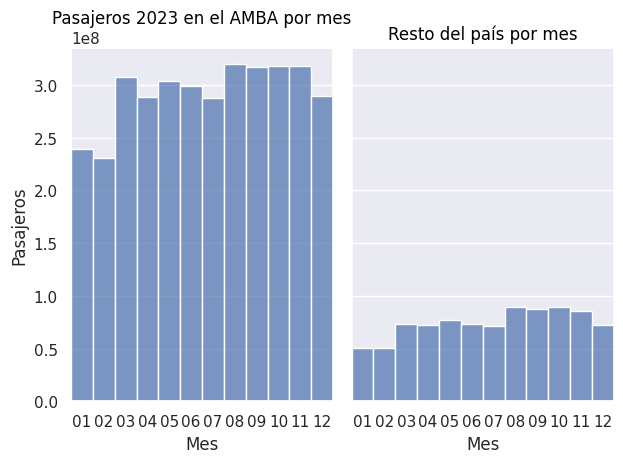

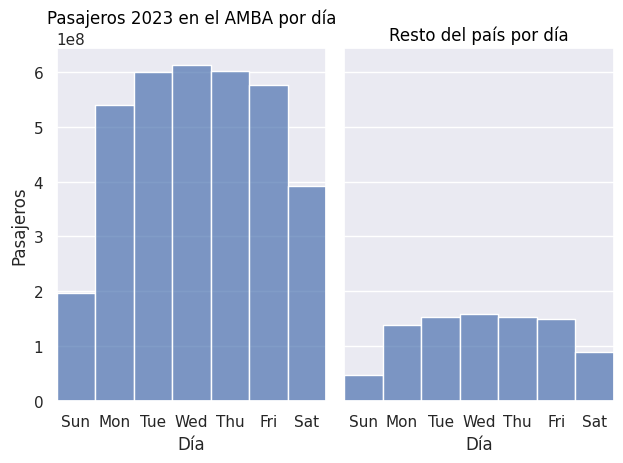

In [249]:
def titulo(amba, tiempo):
    title = "Pasajeros 2023"
    if (amba == "SI"):
        return f"{title} en el AMBA por {tiempo}"
    return f"Resto del país por {tiempo}"

so.Plot(datos_totales, x="fecha_mes", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(x="Mes", y="Pasajeros").facet("amba").label(title=lambda x: titulo(x, "mes")).show()
so.Plot(datos_totales, x="fecha_dia", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(x="Día", y="Pasajeros").facet("amba").label(title=lambda x: titulo(x, "día")).show()


#### Se ve claramente que en Enero y Febrero hay menos pasajeros, esto es de esperar suponiendo que muchas personas se toman vacaciones sumado al receso escolar y universitario, ademas se observa una disminucion del uso del transporte publico los fines de semana. Más alla de la diferencia de cantidad, se ve la misma tendencia tanto en el amba como en el resto del país.


Ahora respondamos cual es la varianza de la cantidad de pasajeros en el AMBA durante el año 2023

In [243]:
varianza_amba = datos_amba['pasajeros'].var()
print(f"La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: {round(varianza_amba, 2)}")
# Ahora comparamos con la varianza en el resto de Argentina
datos_no_amba = datos[datos["AMBA"] == "NO"].dropna()
varianza_no_amba = datos_no_amba["CANTIDAD"].var()
print(f"La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: {round(varianza_no_amba, 2)}")

print(f"La varianza del AMBA es {round(varianza_amba/varianza_no_amba, 2)} mayor a la del resto de Argentina")


La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: 1016641795.39
La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: 13214597.42
La varianza del AMBA es 76.93 mayor a la del resto de Argentina


Esto nos da una pista de la distribucion de los datos en el AMBA. Se ve que los datos estan "Muy alejados entre si" en relacion al resto del país

#### Ahora vamos a comparar como se distribuyen en el mapa de argentina
##### Queremos hacer un mapa de calor del territorio Argentino que muestre:
 $$\dfrac{pasajeros}{habitantes \cdot 365}$$

Decidimos usar un mapa, dado a que hacer un histograma con tantos valores en el eje x (provincias) podría ser confuso y aparte nos permite analizar la distribución espacial.

##### Para esto seguimos los siguientes pasos:
1. Importamos el geoJson de argentina y lo guardamos en un DataFrame
1. Guardamos en ese dataframe la cantidad de pasajeros (en sus respectivas provincias)
1. Obtenemos los datos de habitantes por provincia ([Fuente](https://censo.gob.ar/index.php/datos_definitivos/))
1. En el DataFrame agregamos una nueva columna "cantidad_proporcional" haciendo pasajeros/habitantes
1. Luego calculamos la "cantidad_proporcional_diaria" que representa el dato que buscamos, cuantos pasajeros utilizan el transporte público por día en dicha provincia, pasajeros/(habitantes * 365)
1. Finalmente hacemos el mapa de calor!

In [278]:
df = gpd.read_file("https://labo-datos-next-psi.vercel.app/api/argentina/map") # Cargo el Mapa de argentina (devuelve un dataframe con columna nombre y las posiciones en el mapa)

def graficar_mapa(tipo_de_transporte):
    datos_mapa = datos[(datos["PROVINCIA"] != "JN") & (datos["TIPO_TRANSPORTE"] == tipo_de_transporte)] # Saco los de Jurisdiccion nacional ( no son muy signigicativos en el total 5% aprox)
    datos_mapa = datos_mapa.groupby("PROVINCIA").sum("CANTIDAD") # Tomo los totales
    df["nombre"] = df["nombre"].apply(str.upper) # pasamos a mayuscula los nombres del GEOJSON para poder comparar con las que ya tenemos
    df["cantidad"] = [datos_mapa['CANTIDAD'][provincia] if provincia in datos_mapa.index else 0 for provincia in df["nombre"]] # agrego la columna cantidad al geojson

    # Ahora le introducimos la poblacion de cada provincia (FUENTE https://censo.gob.ar/index.php/datos_definitivos/)
    url_poblacion = "https://labo-datos-next-psi.vercel.app/api/argentina/poblacion"
    response = requests.get(url_poblacion)
    data_poblacion = pd.DataFrame(response.json())

    # Sumamos CABA a Buenos Aires
    habitantes_caba = data_poblacion[data_poblacion["provincia"] == "Ciudad Autónoma de Buenos Aires"]["habitantes"]
    data_poblacion.iloc[data_poblacion[data_poblacion["provincia"] == "Buenos Aires"].index, 1] += habitantes_caba.values[0]
    data_poblacion["provincia"] = data_poblacion["provincia"].apply(str.upper) # lo pasamos a mayuscula para poder comparar con el geojson
    df["habitantes"] = [data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"].values[0] if len(data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"]) else 0  for provincia in df["nombre"]] # calculamos la proporcion de pasajeros por habitante
    df["cantidad_proporcional"] = df["cantidad"] / df["habitantes"] # calculamos la proporcion de pasajeros por habitante
    df["cantidad_proporcional_diaria"] = df["cantidad_proporcional"] / 365 # calculamos la proporcion de pasajeros por dia y habitante

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(column='cantidad_proporcional_diaria', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    def text_format(n):
        if (n == 0):
            return ""

        return f"{round(n, 2) }"

    def color_format(n):
        if(n > 0.2):
            return '#ffffff'

        return '#000000'

    for i, row in df.iterrows():
        ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            text_format(row['cantidad_proporcional_diaria']),
            horizontalalignment='center',
            color=color_format(row['cantidad_proporcional_diaria'])
        )

    plt.title(f'Pasajeros de {tipo_de_transporte.lower()} por dia \n en proporción a la cantidad de habitantes')
    plt.show()
    display(df[["nombre", "cantidad", "cantidad_proporcional", "cantidad_proporcional_diaria", "habitantes"]].set_index("nombre"))



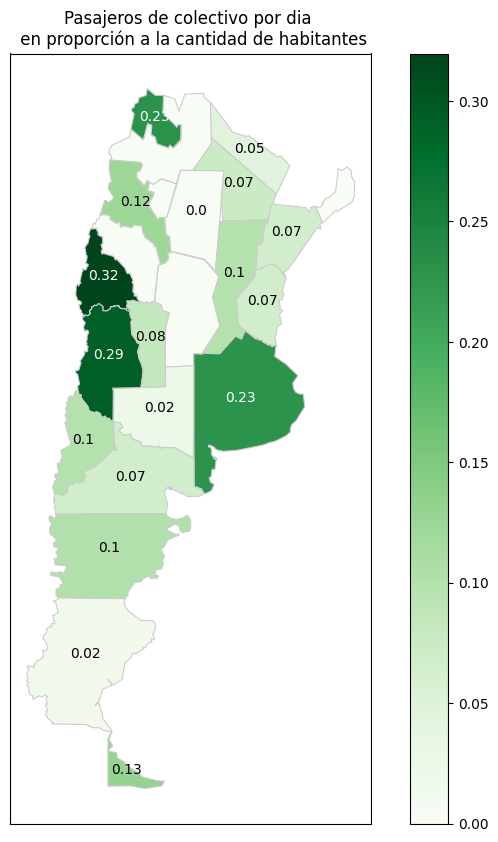

,cantidad,cantidad_proporcional,cantidad_proporcional_diaria,habitantes
nombre,,,,
TUCUMÁN,0,0.000000,0.000000,1731820
SANTIAGO DEL ESTERO,117939,0.111168,0.000305,1060906
SALTA,0,0.000000,0.000000,1441351
JUJUY,68183741,84.010371,0.230165,811611
FORMOSA,10227663,16.837904,0.046131,607419
CHACO,30895035,27.350275,0.074932,1129606
MISIONES,0,0.000000,0.000000,1278873
CORRIENTES,28895819,23.827752,0.065282,1212696
CATAMARCA,19405862,45.175928,0.123770,429562


In [279]:
graficar_mapa("COLECTIVO")

Una aclaración importante, Además de que falten las Malvinas, tomamos los habitantes de Buenos Aires como CABA + Buenos Aires. Pero el dataframe de sube-2023 no tiene provincia CABA por lo que puede afectar los resultados.

Otra aclaracion es que muchas provincias no tienen datos por que tienen lineas de Jurisdicción Nacional, por lo tanto no tienen provincia asignada.

Ahora sí, notemos que BS.AS, más alla tener por muchísimo mas pasajeros durante el año, tiene menos pasajeros diaros en proporcion a sus habitantes. Hay que remarcar que estos datos son de colectivo, dado a que **quizas** en CABA al utilizarse mucho los subtes este numero baja bastante **Más adelante lo veremos**.

No fue posible graficar srenes dado a que eran de jurisdicción nacional, lo mismo nos pasó con los subtes.




##### ¿Cuál es el medio más utilizado y su proporción? ¿A qué se debe? ¿Será que posee mas lineas/empresas que el resto?

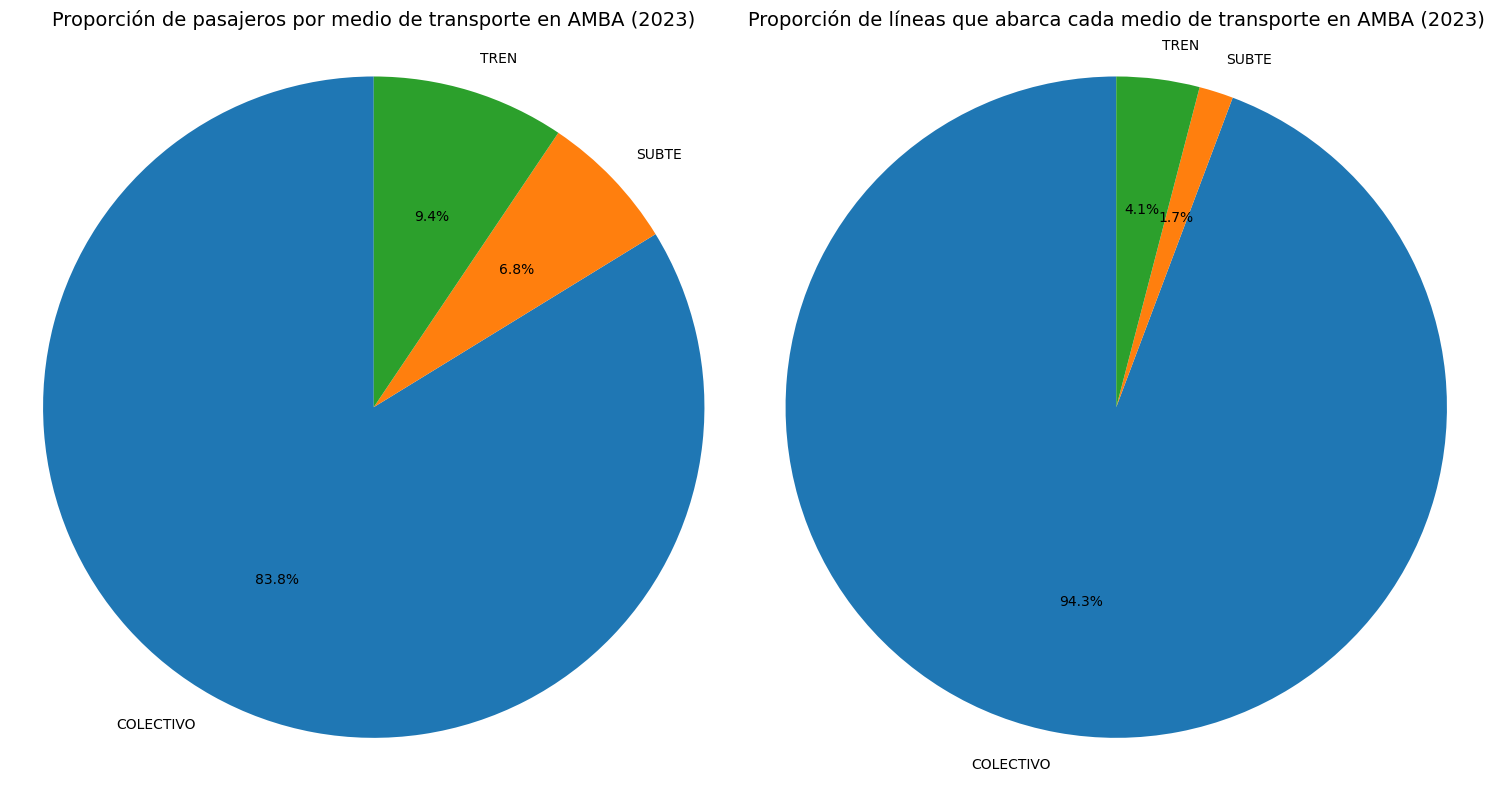

In [284]:
# Calculamos la proporción de pasajeros por cada tipo de transporte
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum().reset_index()
proporcion_transporte['proporcion'] = proporcion_transporte['pasajeros'] / datos_amba['pasajeros'].sum()

# Calcular la proporción de líneas que abarcan cada tipo de transporte
lineas_por_transporte_amba = datos_amba.groupby('tipo_transporte')['linea'].nunique().reset_index()
lineas_por_transporte_amba.columns = ['tipo_transporte', 'cantidad']

total_lineas_amba = lineas_por_transporte_amba['cantidad'].sum()
lineas_por_transporte_amba['proporcion'] = lineas_por_transporte_amba['cantidad'] / total_lineas_amba


fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Gráfico de torta para la proporción de pasajeros
axs[0].pie(proporcion_transporte['proporcion'], labels=proporcion_transporte['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Proporción de pasajeros por medio de transporte en AMBA (2023)', fontsize=14)
axs[0].axis('equal')

# Gráfico de torta para la proporción de líneas
axs[1].pie(lineas_por_transporte_amba['proporcion'], labels=lineas_por_transporte_amba['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Proporción de líneas que abarca cada medio de transporte en AMBA (2023)', fontsize=14)
axs[1].axis('equal')


plt.tight_layout()
plt.show()

Parecería indicar que el colectivo es el transporte que mayor movilidad de personas posee en función de la cantidad de líneas que abarca y ofrece en sus servicios. Ahora bien, nos preguntamos lo siguiente:


#### ¿Cuál es la movilidad de personas que posee cada tipo de transporte en función de las líneas/servicios que posee?

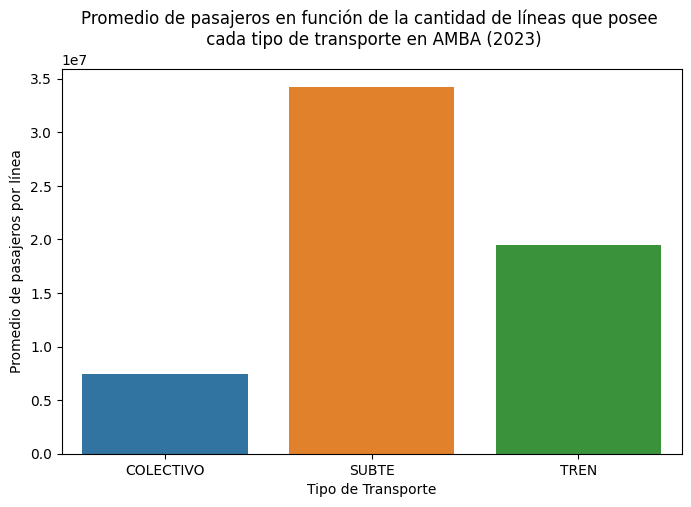

In [285]:
# Calculamos el promedio de pasajeros en función de la cantidad de líneas que tiene cada tipo de transporte
pasajeros_por_linea = proporcion_transporte.merge(lineas_por_transporte_amba, on='tipo_transporte')
pasajeros_por_linea['pasajeros_por_linea'] = pasajeros_por_linea['pasajeros'] / pasajeros_por_linea['cantidad']

plt.figure(figsize=(8, 5))
grafico = sns.barplot(data=pasajeros_por_linea,x="tipo_transporte",y="pasajeros_por_linea",hue="tipo_transporte",)
plt.title("Promedio de pasajeros en función de la cantidad de líneas que posee \n cada tipo de transporte en AMBA (2023)")
plt.xlabel("Tipo de Transporte")
plt.ylabel("Promedio de pasajeros por línea")
plt.show()

Es decir, podemos ver que el SUBTE en líneas generales es el que menor movilidad de personas posee en el año, pero a nivel de cantidad de líneas/servicios que ofrece es el que mayor cantidad de personas abarca en promedio. Esto puede deberse a una mayor eficiencia en términos de distancias recorridas/tiempos/costos

#### ¿Cúales son las empresas que poseen la mayor cantidad de pasajeros a nivel colectivos?

In [298]:
resultados_por_empresa = datos_totales.copy()
resultados_por_empresa = resultados_por_empresa[(resultados_por_empresa['amba'] == 'SI') & (resultados_por_empresa['dato_preliminar'] == "NO") & (resultados_por_empresa['tipo_transporte'] == "COLECTIVO")]
resultados_por_empresa = resultados_por_empresa.groupby('nombre_empresa').agg(
    total_de_pasajeros=('pasajeros', 'sum'),
    cantidad_de_líneas=('linea', 'nunique'),
    lineas=('linea', lambda x: list(set(x))),
    cantidad_de_municipios=('municipio', 'nunique'),
    municipios=('municipio', lambda x: list(set(x)))
).reset_index()


# Ordenamos a nuestro DataFrame según la cantidad total de pasajeros
resultados_por_empresa = resultados_por_empresa.sort_values(by='total_de_pasajeros', ascending=False)

# Realizamos un DataFrame en el cuál nos muestres las top 5 empresas
top_5_empresas = resultados_por_empresa.head(5)
top_5_empresas


,nombre_empresa,total_de_pasajeros,cantidad_de_líneas,lineas,cantidad_de_municipios,municipios
132,TRANSPORTES LA PERLITA S.A.,91144040,7,"[BSAS_LINEA_329, BSAS_LINEA_312, BSAS_LINEA_50...",3,"[SN, MORENO, GENERAL RODRIGUEZ]"
40,EMPRESA LINEA 216 S.A.T.,85937290,9,"[BSAS_LINEA_166, BSAS_LINEA_504A, BSAS_LINEA_6...",5,"[SD, MORON, SN, ITUZAINGO, MERLO]"
63,LA CABAÑA S.A.,66374356,7,"[BSAS_LINEA_242, BSAS_LINEA_624, BSAS_LINEA_31...",4,"[SD, SN, MORON, LA MATANZA]"
60,GENERAL TOMAS GUIDO S.A.C.I.F.,62128231,9,"[BSAS_LINEA_299, BSAS_LINEA_271, BSAS_LINEA_37...",3,"[AVELLANEDA, SD, SN]"
66,LA NUEVA METROPOL S.A.,54419476,5,"[BSAS_LINEA_195, BSAS_LINEA_065, BSAS_LINEA_22...",2,"[SD, SN]"


#### ¿En que municipios estan distribuidas estas empresas?

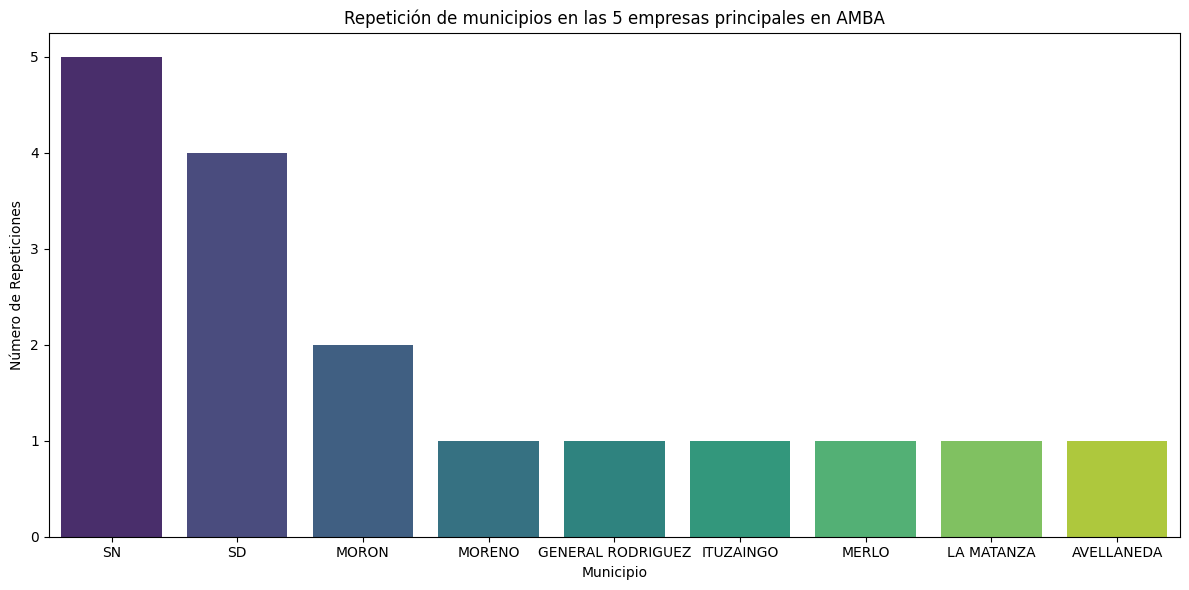

In [303]:
municipios_expandidos = top_5_empresas.explode('municipios')
municipio_frecuencias = municipios_expandidos['municipios'].value_counts().reset_index()
municipio_frecuencias.columns = ['municipio', 'repeticiones']
plt.figure(figsize=(12, 6))
sns.barplot(data= municipio_frecuencias, x='municipio', y='repeticiones', hue = 'municipio',palette='viridis')
plt.title('Repetición de municipios en las 5 empresas principales en AMBA')
plt.xlabel('Municipio')
plt.ylabel('Número de Repeticiones')
plt.tight_layout()
plt.show()


####¿Que líneas posee "x" empresa?

In [309]:
nombre_empresa_especifica = "GENERAL TOMAS GUIDO S.A.C.I.F."
empresa_especifica = top_5_empresas[top_5_empresas['nombre_empresa'] == nombre_empresa_especifica]
print(f"Las líneas que posee la empresa {nombre_empresa_especifica} son:")
print(empresa_especifica['lineas'].values[0])

Las líneas que posee la empresa GENERAL TOMAS GUIDO S.A.C.I.F. son:
['BSAS_LINEA_299', 'BSAS_LINEA_271', 'BSAS_LINEA_373', 'BSAS_LINEA_084', 'BSAS_LINEA_384', 'BSAS_LINEA_570', 'BSAS_LINEA_009', 'LINEA_164_AMBA', 'BSAS_LINEA_25']


#### ¿En que empresa se encuentra "X" línea?

In [310]:
nombre_linea_especifica = "BSAS_LINEA_009"
empresas_con_linea_especifica = resultados_por_empresa[resultados_por_empresa['lineas'].apply(lambda x: nombre_linea_especifica in x)]
empresa_encontrada = empresas_con_linea_especifica['nombre_empresa'].values[0]
print(f"La empresa que posee a la línea {nombre_linea_especifica} es: {empresa_encontrada}")


La empresa que posee a la línea BSAS_LINEA_009 es: GENERAL TOMAS GUIDO S.A.C.I.F.


### **Modelado**

5. Modelo de regresión. En este ítem, intentaremos ajustar la cantidad de pasajeros que viajan por día en una línea de colectivos utilizando la información de pasajeros por día de otras líneas. Para esto, utilizaremos el dataset sube-2023-regresion.csv

 #### a. Generar un DataFrame en el que las columnas sean las líneas de colectivo (TIPO_TRANSPORTE == "COLECTIVO") de AMBA de jurisdicción nacional (PROVINCIA == "JN") y las observaciones sean los días del año. Es decir, cada fila del DataFrame corresponde a un día del año, y en esa fila deben figurar la cantidad de pasajeros que viajaron en cada línea de colectivo en el día correspondiente.

In [10]:
datos_regresion = pd.read_csv('sube-2023-regresion.csv')

In [11]:
datos_ColectivoJN = datos_regresion[(datos_regresion['AMBA'] == 'SI') & (datos_regresion['PROVINCIA'] == 'JN') & (datos_regresion['TIPO_TRANSPORTE'] == 'COLECTIVO')]


cols = datos_ColectivoJN['LINEA'].unique()
pasajeros_por_linea = pd.DataFrame()

for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN['LINEA'] == col][['DIA_TRANSPORTE', 'CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns={'CANTIDAD': col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis=1)

####b. Eliminar las columnas correspondientes a líneas de colectivo que tengan datos faltantes.


In [12]:
#Corroboramos de que efectivamente haya valores nulos
pasajeros_por_linea.isnull().values.any()

True

In [13]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis = 1)



#### c,d,e,f.  

*   Se quiere ajustar la cantidad de pasajeros en la línea BSAS_LINEA_009 en función de los
pasajeros en otras líneas. Proponer tres modelos de regresión distintos. En cada modelo,
pueden utilizarse la información solo de otras 5 líneas de colectivos (pueden ser distintas
líneas de colectivo en los distintos modelos). Los criterios de selección de esas 5 columnas
los determinan ustedes, y deben estar explicitados en el informe

*   Si alguno de los modelos es Regresión Ridge, determinar mediante un esquema de validación el hiperparámetro α.

*    Proponer un esquema de validación de los modelos y utilizarlo para seleccionar el mejor
de los tres modelos propuestos.

*   Para el modelo elegido, indicar la fórmula final de modelo.


##### **Modelos**

In [45]:
#Generamos un DataFrame en el cuál estaremos trabajando en nuestros modelos, en el cuál este estara normalizado en sus valores para poseer las mismas escalas
datos_lineas = pasajeros_por_linea.copy()
datos_lineas = datos_lineas.div(pasajeros_por_linea.max())
datos_lineas.columns = datos_lineas.columns.str.replace(' ', '_').str.replace('.', '_')
datos_lineas.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA_4,LINEA_42,LINEA_44,LINEA_50,LINEA_6,LINEA_7,LINEA_76,LINEA_8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.103319,0.147391,0.132138,0.143047,0.131104,0.138135,0.062495,0.095195,0.129099,0.085118,...,0.116239,0.100159,0.126617,0.163386,0.100567,0.093317,0.120086,0.085400,0.089756,0.080985
2023-01-02,0.580209,0.565624,0.545127,0.585118,0.651549,0.590163,0.542391,0.434106,0.639016,0.534325,...,0.605650,0.474121,0.555247,0.547692,0.430601,0.545804,0.549480,0.373434,0.492274,0.488483
2023-01-04,0.647818,0.643505,0.594784,0.657788,0.760993,0.662983,0.630094,0.486195,0.709225,0.626440,...,0.704702,0.537190,0.642618,0.622886,0.500698,0.596009,0.628103,0.422326,0.571395,0.549588
2023-01-05,0.639705,0.669942,0.620162,0.682159,0.769096,0.692982,0.645562,0.470299,0.718291,0.651836,...,0.712920,0.546736,0.645124,0.624000,0.529238,0.626730,0.671590,0.437135,0.562142,0.579560
2023-01-06,0.647203,0.676415,0.619437,0.667763,0.765166,0.693573,0.641276,0.471245,0.729989,0.651179,...,0.716002,0.557376,0.646322,0.651653,0.521641,0.606691,0.742338,0.434838,0.551650,0.590635


In [46]:
# Separamos a nuestro DataFrame en uno de entranimiento y otro de testo, con una proporción de 80% para el primero y 20% para el segundo.
df_train, df_test = train_test_split(datos_lineas, test_size=0.2, random_state=42)

######**Modelo 1**

¿Qué es lo que haremos para este primer modelo?

* Lo primero será crear un pseudo modelo denotado modelo **"madre"**, en el cuál este modelo será formado como:

  **'BSAS_LINEA_009 ~ Linea_Xi + Linea_Xi+1 ... + Linea_xn-1 + Linea_xn"**, donde se sumaran todas las líneas salvo la que queremos inferir.


¿Por qué hacemos esto?

* Porque consideramos que será el que mejor aproxime a nuestro modelo, ahora bien a la hora de realizar este modelo tendremos que tener en cuenta la posible colinealidad que haya entre coeficientes y por ende en la dependencia que haya entre líneas. Por esto mismo, para este modelo "Madre" utilizaremos el método de **regresión de Ridge** y posteriormente nos quedaremos con las **5 líneas que mayor ponderancia** poseen en peso en nuestro modelo, así posteriormente podemos realizar a nuestro **"Modelo 1"** como las 5 líneas que mejor ponderaron en nuestro modelo "Madre"

In [229]:
#Generamos la fórmula que será la sumatoria de todos nuestros campos correspondientes a la línea, salvo la línea a inferir
linea = 'BSAS_LINEA_009'
otras_lineas = [col for col in datos_lineas.columns if col != linea]
formula = f'{linea} ~ ' + ' + '.join(otras_lineas)

In [230]:
# Construimos las matrices X e y para entrenamiento de nuestro modelo madre
y, X =  Formula(formula).get_model_matrix(df_train)

#Generamos un vector de hiperpárametros alphas con distintas magnitudes en un primer acercamiento
alphas = np.array([0.1, 0.3, 0.5, 0.8,1 , 3, 5])

for alpha in alphas:
    # Inicializamos un modelo de Regresion de Ridge sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)  # Realizamos KFold con 5 pliegos
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raíz del Error Cuadratico Medio es: {rmse.mean():.5f}")

Para alpha = 0.10000 la raíz del Error Cuadratico Medio es: 0.04566
Para alpha = 0.30000 la raíz del Error Cuadratico Medio es: 0.04434
Para alpha = 0.50000 la raíz del Error Cuadratico Medio es: 0.04421
Para alpha = 0.80000 la raíz del Error Cuadratico Medio es: 0.04453
Para alpha = 1.00000 la raíz del Error Cuadratico Medio es: 0.04485
Para alpha = 3.00000 la raíz del Error Cuadratico Medio es: 0.04785
Para alpha = 5.00000 la raíz del Error Cuadratico Medio es: 0.04981


Podemos ver que en este primer acercamiento el alpha a buscar se encontrá dentro del rango de [0.3, ...., 0.8]

In [231]:
#Volvemos a iterar con valores próximos a este rango
alphas = np.array([0.1, 0.2, 0.3, 0.4, 0.45,0.5, 0.6, 0.7,0.8])

for alpha in alphas:
    # Inicializamos un modelo de Regresion de Ridge sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego
    ind = 0

    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raiz del error cuadratico medio es: {rmse.mean():.5f}")

Para alpha = 0.10000 la raiz del error cuadratico medio es: 0.04566
Para alpha = 0.20000 la raiz del error cuadratico medio es: 0.04469
Para alpha = 0.30000 la raiz del error cuadratico medio es: 0.04434
Para alpha = 0.40000 la raiz del error cuadratico medio es: 0.04421
Para alpha = 0.45000 la raiz del error cuadratico medio es: 0.04420
Para alpha = 0.50000 la raiz del error cuadratico medio es: 0.04421
Para alpha = 0.60000 la raiz del error cuadratico medio es: 0.04428
Para alpha = 0.70000 la raiz del error cuadratico medio es: 0.04439
Para alpha = 0.80000 la raiz del error cuadratico medio es: 0.04453


Podemos ver que el alpha óptimo es alpha = 0.45000

In [232]:
alpha_optimo = 0.45
modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)
modeloRidge.fit(X, y)

# Construimos las matrices X e y para entrenamiento
y_test, X_test =  Formula(formula).get_model_matrix(df_test)

y_pred = modeloRidge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"For alpha = {alpha_optimo:.5f} the Root Mean Squared Error is: {rmse.mean():.5f}")
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

For alpha = 0.45000 the Root Mean Squared Error is: 0.04024
R^2:  0.9691767077063395


Ahora bien este modelo madre utiliza a todas las demás líneas correspondientes, por lo que deberíamos de visualizar sus coeficientes y seleccionar aquellos que mayor ponderancia y aporte al modelo tengan.

Primero realizamos una gráfica para observar la distribución de estos coeficientes:

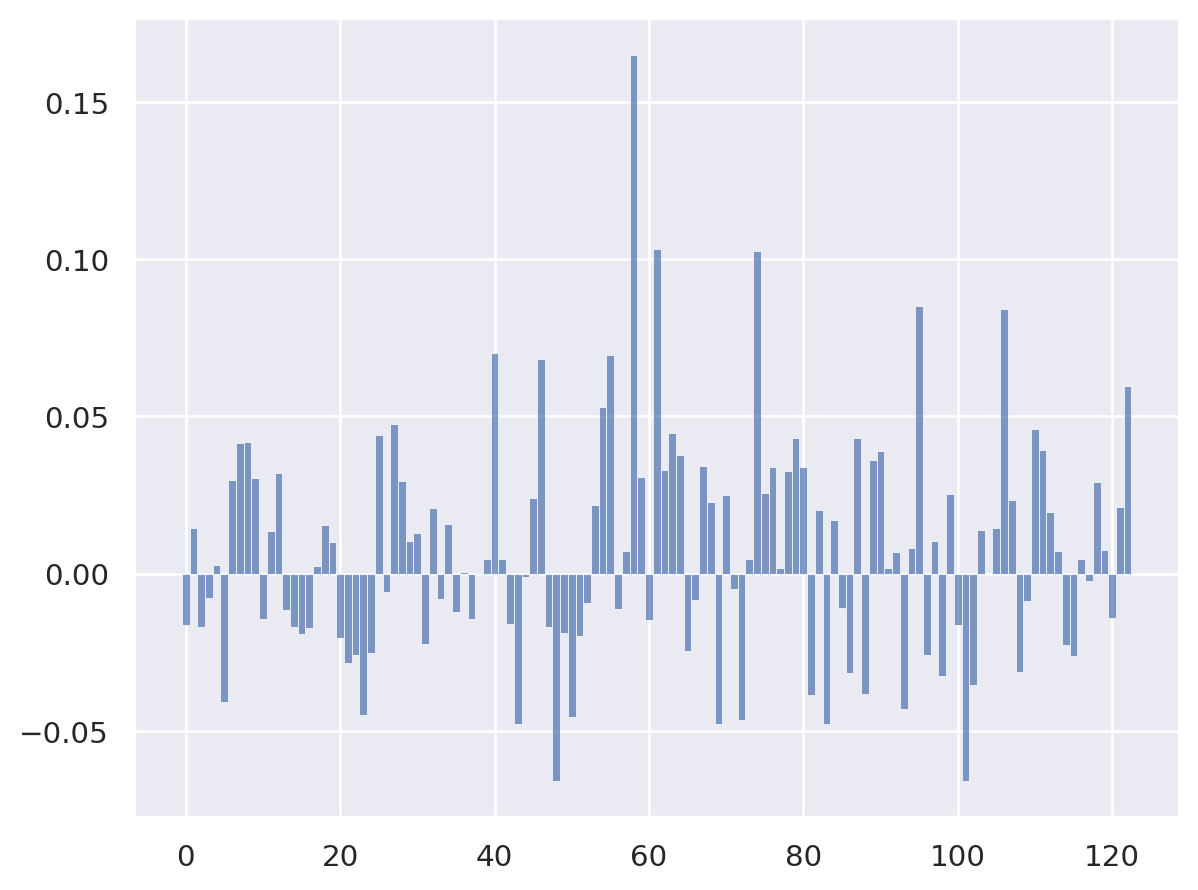

In [233]:
#Observamos a los coeficientes utilizados sin el valor del intercept
coeficientes = modeloRidge.coef_.flatten()
(
    so.Plot(x = np.array(range(len(coeficientes[1:]))), y = coeficientes[1:] )
    .add(so.Bars())
)


In [234]:
#Realizamos un data frame en el cuál guardaremos el coeficiente asociado a la línea correspondiente, posteriormente nos querdaremos con los valores modulos y filtraremos a los top 5, obviamente quitamos al intercept
lineas_coeficientes = pd.DataFrame({'Línea': X.columns[1:], 'Coeficiente': coeficientes[1:]})
lineas_seleccionadas_top_5_modulo = lineas_coeficientes.reindex(lineas_coeficientes['Coeficiente'].abs().sort_values(ascending=False).index[:5])
display(lineas_seleccionadas_top_5_modulo)

,Línea,Coeficiente
58,BSAS_LINEA_108,0.165027
61,BSAS_LINEA_111,0.103319
74,BSAS_LINEA_135,0.102616
95,BSAS_LINEA_178,0.084941
106,LINEA_101,0.084067


Observamos que estas 5 líneas encontradas son las que mayor ponderacia y peso tienen el modelo Madre desarrollado, por lo que procederemos a crear al modelo 1:

 **BSAS_LINEA_009 ~ BSAS_LINEA_108 + BSAS_LINEA_111 + BSAS_LINEA_135 + BSAS_LINEA_178 + LINEA_101**

In [235]:
formula_1 = 'BSAS_LINEA_009 ~ BSAS_LINEA_108 + BSAS_LINEA_111 + BSAS_LINEA_135 + BSAS_LINEA_178 + LINEA_101'
y1, X1 = (
    Formula(formula_1)
    .get_model_matrix(df_train)
)

# Definimos los subconjuntos para la validación cruzada.

# Realizamos KFold con 6 pliegos
cv = KFold(n_splits=6, random_state=42, shuffle=True)

# Inicializamos un modelo de Regresion lineal sin intercept
modelo1 = linear_model.LinearRegression(fit_intercept = False)
rmse1 = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0
for train_index, test_index in cv.split(X1):
    X1_train, X1_val, y1_train, y1_val = X1.iloc[train_index], X1.iloc[val_index], y1.iloc[train_index], y1.iloc[val_index]
    modelo1.fit(X1_train, y1_train)

    y1_pred = modelo1.predict(X1_val)
    rmse1[ind] = np.sqrt(mean_squared_error(y1_val, y1_pred))
    ind = ind + 1

print("rmse del Modelo 1 :",rmse1)
print("rmse promedio del Modelo 1:",rmse1.mean())

rmse del Modelo 1 : [0.03517727 0.03451623 0.03506241 0.03511685 0.03376425 0.03543851]
rmse promedio del Modelo 1: 0.034845921382388345


######**Modelo 2**

¿Qué es lo que haremos para este segundo modelo?

* Lo primero que haremos será crear un DataFrame en el cuál esten agrupados las líneas de colectivos que posean el mismo municipio. Posteriormente, eligiremos 5 líneas que poseean el mismo municipio que BSAS_LINEA_009 y a su vez le pediremos la condición de que estas 5 líneas esten dentro de las empresas top 5 en cuanto a la cantidad de personas que abarcan.


¿Por qué hacemos esto?

* Consideramos que debe de haber una relación a la hora de elegir líneas según el municipio en común, por otro lado entendemos que al elegir las líneas que este en las empresas top 5 estás tendran más información de aporte en nuestro modelo.

In [226]:
#Generamos un DataFrame en el cuál tengan agrupadas las líneas que coincidan con el mismo municipio
municipios = datos_totales.copy()
municipios = municipios[(municipios['amba'] == 'SI') & (municipios['dato_preliminar'] == "NO") & (municipios['tipo_transporte'] == "COLECTIVO")]
municipios_por_empresa_lista = municipios.groupby('municipio')['linea'].apply(lambda x: list(set(x))).reset_index()
municipios_por_empresa_lista.columns = ['municipio', 'lineas']

#Ahora bien queremos buscar el municipio en particular de la línea BSAS_LINEA_009, para así entonces obtener a todas las líneas que estan en ese municipio
linea_buscada = 'BSAS_LINEA_009'
lineas_mismo_municipio = municipios_por_empresa_lista[municipios_por_empresa_lista['lineas'].apply(lambda x: linea_buscada in x)]
municipio_lineas = lineas_mismo_municipio['municipio'].iloc[0]
lineas_mismo_municipio = np.array(lineas_mismo_municipio['lineas'].tolist())[0]


#Por otro lado, como para nuestros modelos filtramos el dataFrame quedandonos así con una menor cantidad de líneas, lo que vamos a hacer es filtrar las líneas que abarcan en el municipio de BSAS_LINEA_009 con las del dataFrame
lineas_filtradas = np.array(datos_lineas.columns)
lineas_del_data = np.intersect1d(lineas_mismo_municipio, lineas_filtradas)

#Nos quedamos con las líneas que poseen mismo municpio de BSAS_LINEA_009 y estan en nuestro dataFrame a la hora de realizar el modelo
print(f"Las líneas que posee el mismo municipio '{municipio_lineas}', de BSAS_LINEA_009 son: {lineas_mismo_municipio}")

Las líneas que posee el mismo municipio 'SD', de BSAS_LINEA_009 son: ['BSAS_LINEA_032' 'BSAS_LINEA_041' 'BSAS_LINEA_015' 'BSAS_LINEA_163'
 'BSAS_LINEA_098' 'BSAS_LINEA_146' 'BSAS_LINEA_080' 'LINEA 33'
 'BSAS_LINEA_068' 'BSAS_LINEA_067' 'BSAS_LINEA_111' 'BSAS_LINEA_150'
 'BSAS_LINEA_019' 'BSAS_LINEA_108' 'BSAS_LINEA_126' 'LINEA 101' 'LINEA 12'
 'BSAS_LINEA_055' 'BSAS_LINEA_063' 'LINEA_119_AMBA' 'BSAS_LINEA_115'
 'BSAS_LINEA_117' 'BSAS_LINEA_097' 'BSAS_LINEA_103' 'BSAS_LINEA_182'
 'BSAS_LINEA_188' 'BSAS_LINEA_124' 'LINEA 107' 'BSAS_LINEA_091'
 'BSAS_LINEA_053' 'BSAS_LINEA_062' 'BSAS_LINEA_195' 'BSAS_LINEA_020'
 'BSAS_LINEA_106' 'BSAS_LINEA_174' 'BSAS_LINEA_065' 'BSAS_LINEA_047'
 'BSAS_LINEA_193' 'BSAS_LINEA_154' 'BSAS_LINEA_25' 'LINEA 145'
 'BSAS_LINEA_026' 'BSAS_LINEA_017' 'LINEA 28' 'LINEA 23' 'BSAS_LINEA_021'
 'BSAS_LINEA_140' 'LINEA_164_AMBA' 'BSAS_LINEA_148' 'BSAS_LINEA_010'
 'BSAS_LINEA_159' 'LINEA 8' 'BSAS_LINEA_051' 'BSAS_LINEA_158'
 'BS_ASLINEA_123' 'BSAS_LINEA_022' 'BSAS_LINEA_

In [224]:
# Ahora bien, realizamos un DataFrame en el cuál vamos filtrar las líneas correspondientes al municipio SD que estan en empresas top 5
colectivos = datos_totales.copy()
colectivos = colectivos[(colectivos['amba'] == 'SI') & (colectivos['dato_preliminar'] == "NO") & (colectivos['tipo_transporte'] == "COLECTIVO")]

# Agrupamos por 'empresa', 'municipio' y obtenemos una lista de líneas de colectivos
Empresas_municipios = colectivos.groupby(['nombre_empresa', 'municipio']).agg({'linea': lambda x: list(set(x))}).reset_index()

#Filtramos por nuestro municipio de interés
Empresas_municipios = Empresas_municipios[Empresas_municipios["municipio"] == municipio_lineas]

#Filtramos pór las empresas top 5
empresas_top = Empresas_municipios[Empresas_municipios['nombre_empresa'].isin(top_5_empresas["nombre_empresa"].values)]
lineas_top_5 = empresas_top.copy()
# Convertir las listas de líneas en cadenas de texto
lineas_top_5['linea'] = lineas_top_5['linea'].apply(lambda x: ', '.join(x))
display(lineas_top_5['linea'].values)

array(['BSAS_LINEA_166',
       'BSAS_LINEA_25, BSAS_LINEA_009, BSAS_LINEA_084, LINEA_164_AMBA',
       'BSAS_LINEA_172, BSAS_LINEA_174',
       'BSAS_LINEA_065, BSAS_LINEA_195, BSAS_LINEA_194'], dtype=object)

Ahora estamos en condiciones de elegir las líneas que poseen el mismo municipío que BSAS_LINEA_009 y están en las empresas top 5.

Para este modelo, elegiremos a las líneas según el orden correspondiente y sin contarse así misma.

Por lo que el modelo será:

 **BSAS_LINEA_009 ~ BSAS_LINEA_166 + BSAS_LINEA_25 + BSAS_LINEA_084 + LINEA_164_AMBA + BSAS_LINEA_172**

In [236]:
formula_2 = 'BSAS_LINEA_009 ~ BSAS_LINEA_166 + BSAS_LINEA_25 + BSAS_LINEA_084 + LINEA_164_AMBA + BSAS_LINEA_172'

y2, X2 = (
    Formula(formula_2)
    .get_model_matrix(df_train)
)

# Definimos los subconjuntos para la validación cruzada.
# Realizamos KFold con 6 pliegos
cv = KFold(n_splits=6, random_state=42, shuffle=True)

# Inicializamos un modelo de Regresion lineal sin intercept
modelo2 = linear_model.LinearRegression(fit_intercept = False)
rmse2 = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0

for train_index, test_index in cv.split(X2):
    X2_train, X2_val, y2_train, y2_val = X2.iloc[train_index], X2.iloc[val_index], y2.iloc[train_index], y2.iloc[val_index]
    modelo2.fit(X2_train, y2_train)

    y2_pred = modelo2.predict(X2_val)
    rmse2[ind] = np.sqrt(mean_squared_error(y2_val, y2_pred))
    ind = ind + 1

print("rmse del Modelo 2 :",rmse1)
print("rmse promedio del Modelo 2:",rmse1.mean())

rmse del Modelo 2 : [0.03517727 0.03451623 0.03506241 0.03511685 0.03376425 0.03543851]
rmse promedio del Modelo 2: 0.034845921382388345


######**Modelo 3**

######**Modelo eligido**

Dadas las pruebas realizadas con los modelos anteriores, hemos elegido al modelo 1 como el que mayor rendimiento posee en cuanto a la predicción y error cometidos.

Por lo que el modelo ganador es:


**BSAS_LINEA_009 ~ BSAS_LINEA_108 + BSAS_LINEA_111 + BSAS_LINEA_135 + BSAS_LINEA_178 + LINEA_101**

In [311]:
# Ajustamos a nuestro modelo ganador en TODO el conjunto de entrenamiento.
modelo1.fit(X1, y1)

# Realizamos las mismas transformaciones en el conjunto de testeo
y1_test, X1_test = (
    Formula(formula_1)
    .get_model_matrix(df_test)
)

# Predicciones
y1_pred = modelo1.predict(X1_test)

# Bondad del ajuste
r2 = r2_score(y1_test, y1_pred)
print('R^2 del modelo 1 : ', r2)
ecm = mean_squared_error(y1_test, y1_pred)
print('ECM del modelo 1: ', np.sqrt(ecm))

R^2 del modelo 1 :  0.9614462573688983
ECM del modelo 1:  0.04500665241971581
